In [1]:
import sys, os
p = os.path.abspath('..')
# p = p+r'\config'
sys.path.insert(1, p)

In [2]:
import pandas as pd
import re
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import lib.stats.stats as st


In [3]:
path = f'./result/'
file_list = os.listdir(path)

In [4]:
def make_one_file(ver):
    path = f'./result/{ver}'
    file_list = os.listdir(path)
    df = pd.DataFrame()
    if len(file_list)>0 : 
        for f in file_list:
            tmp = pd.read_csv(f'{path}/{f}', index_col =0)
            df = pd.concat([df, tmp], axis =0)

        df.sort_values(by = ['creationdate']).reset_index(drop=True)
        return df
    else :
        return np.NAN

In [5]:
def pp_date(df):
    df = df.sort_values(by = ['creationdate'])
    df_date = df[['creationdate']].drop_duplicates().reset_index(drop=True)
    return df_date
        

In [6]:
def pp_df(df, sc_num):
    df_copy = df.copy()
    df_copy['creationdate'] = pd.to_datetime(df_copy['creationdate'])
    df_copy.loc[:, 'rel_day'] = df_copy.loc[:,  'creationdate'] - datetime.datetime(2022,11,30)
    df_copy.loc[:, 'rel_days'] = df_copy.loc[:, 'rel_day'].dt.days

    df_c = df.copy()
    df_c = df_c[~df_c['result'].isna()]
    df_c['o_result'] = df_c['result'].apply(lambda x : re.sub(r'[^0-9]', '', x))
    df_c = df_c[df_c['o_result'].isin(['1', '0', '2'])]
    
    df_c.loc[:, 'cnt'] = 1
    chk_cnt = df_c.groupby(['id', 'o_result']).count().reset_index()[['id', 'o_result', 'cnt']]
    chk_cnt = chk_cnt[chk_cnt['cnt'] == sc_num]


    m_chk_cnt = pd.merge(chk_cnt, df_copy, on = 'id')
        
    return m_chk_cnt
        



In [7]:
def calc_rate(df):
    df_c = df.copy()
    df_c = df_c[['ver', 'creationdate', 'id', 'o_result', 'rel_days']].drop_duplicates()
    df_c.loc[:, 'r_cnt'] = 1
    
    df_c = df_c.groupby(['ver', 'creationdate', 'rel_days', 'o_result']).count().reset_index()[['ver', 'creationdate', 'rel_days'	,'o_result',	'r_cnt']]
    tot_df = df_c.groupby(['ver', 'creationdate', 'rel_days']).sum().reset_index()[['creationdate', 'r_cnt']].rename(columns = {'r_cnt':'tot_cnt'})

    return_df = pd.merge(df_c, tot_df, on = 'creationdate' )

    return_df['rate'] = return_df['r_cnt']/return_df['tot_cnt']*100
    return_df = return_df.sort_values(by = ['creationdate'])

    return return_df
        



In [8]:
sample_list = sorted([y for y in [x for x in file_list if x.isdigit()] if int(y)>=50000])

In [9]:
print(type(pd.DataFrame()))

<class 'pandas.core.frame.DataFrame'>


In [10]:
tot_calc = pd.DataFrame()
for listid in sample_list:
    df = make_one_file(listid)
    if isinstance(df, pd.core.frame.DataFrame):
        df = pp_df(df, 5)
        df = calc_rate(df)
        tot_calc = pd.concat([tot_calc, df], axis = 0)

    

In [11]:
tot_calc

,ver,creationdate,rel_days,o_result,r_cnt,tot_cnt,rate
0,200000,2021-12-20,-345,0,5,23,21.739130
1,200000,2021-12-20,-345,1,16,23,69.565217
2,200000,2021-12-20,-345,2,2,23,8.695652
0,200001,2022-01-20,-314,0,8,25,32.000000
1,200001,2022-01-20,-314,1,15,25,60.000000
...,...,...,...,...,...,...,...
1,50137,2022-12-05,5,1,15,20,75.000000
2,50137,2022-12-05,5,2,2,20,10.000000
0,50138,2023-01-05,36,0,5,19,26.315789
1,50138,2023-01-05,36,1,13,19,68.421053


In [12]:
df_date = pp_date(tot_calc)

In [13]:
df_date.head()

,creationdate
0,2021-12-05
1,2021-12-20
2,2021-12-25
3,2022-01-05
4,2022-01-20


In [14]:
tot_calc.head()

,ver,creationdate,rel_days,o_result,r_cnt,tot_cnt,rate
0,200000,2021-12-20,-345,0,5,23,21.739130
1,200000,2021-12-20,-345,1,16,23,69.565217
2,200000,2021-12-20,-345,2,2,23,8.695652
0,200001,2022-01-20,-314,0,8,25,32.000000
1,200001,2022-01-20,-314,1,15,25,60.000000


In [15]:
tot_calc[tot_calc['creationdate'] =='2021-12-05']

,ver,creationdate,rel_days,o_result,r_cnt,tot_cnt,rate
0,50000,2021-12-05,-360,0,4,21,19.047619
1,50000,2021-12-05,-360,1,15,21,71.428571
2,50000,2021-12-05,-360,2,2,21,9.523810
0,50025,2021-12-05,-360,0,5,23,21.739130
1,50025,2021-12-05,-360,1,16,23,69.565217
2,50025,2021-12-05,-360,2,2,23,8.695652
0,50050,2021-12-05,-360,0,7,17,41.176471
1,50050,2021-12-05,-360,1,9,17,52.941176
2,50050,2021-12-05,-360,2,1,17,5.882353
0,50075,2021-12-05,-360,0,8,16,50.000000


In [16]:
m_chk_cnt_0 = tot_calc[tot_calc['o_result'] =='0']
m_chk_cnt_1 = tot_calc[tot_calc['o_result'] =='1']
m_chk_cnt_2 = tot_calc[tot_calc['o_result'] =='2']

In [17]:
m_chk_cnt_0

,ver,creationdate,rel_days,o_result,r_cnt,tot_cnt,rate
0,200000,2021-12-20,-345,0,5,23,21.739130
0,200001,2022-01-20,-314,0,8,25,32.000000
0,200002,2022-02-20,-283,0,7,20,35.000000
0,200003,2022-03-20,-255,0,7,21,33.333333
0,200004,2022-04-20,-224,0,8,21,38.095238
...,...,...,...,...,...,...,...
0,50134,2022-09-05,-86,0,5,20,25.000000
0,50135,2022-10-05,-56,0,5,23,21.739130
0,50136,2022-11-05,-25,0,5,21,23.809524
0,50137,2022-12-05,5,0,3,20,15.000000


In [18]:
m_chk_cnt_0 = pd.merge(df_date, m_chk_cnt_0[['creationdate', 'rel_days', 'o_result', 'rate']], on = 'creationdate', how='left')
m_chk_cnt_1 = pd.merge(df_date, m_chk_cnt_1[['creationdate', 'rel_days', 'o_result', 'rate']], on = 'creationdate', how='left')
m_chk_cnt_2 = pd.merge(df_date, m_chk_cnt_2[['creationdate', 'rel_days', 'o_result', 'rate']], on = 'creationdate', how='left')

In [19]:
m_chk_cnt_0.loc[m_chk_cnt_0['o_result'].isna(), 'rate'] = 0
m_chk_cnt_1.loc[m_chk_cnt_1['o_result'].isna(), 'rate'] = 0
m_chk_cnt_2.loc[m_chk_cnt_2['o_result'].isna(), 'rate'] = 0

In [20]:
m_chk_cnt_0.loc[:, 'o_result'] = '0'
m_chk_cnt_1.loc[:, 'o_result'] = '1'
m_chk_cnt_2.loc[:, 'o_result'] = '2'

In [21]:
m_chk_cnt_0.head()

,creationdate,rel_days,o_result,rate
0,2021-12-05,-360,0,19.047619
1,2021-12-05,-360,0,21.739130
2,2021-12-05,-360,0,41.176471
3,2021-12-05,-360,0,50.000000
4,2021-12-05,-360,0,25.000000


In [22]:
# major_xticks = df_date['creationdate'].apply(lambda x : str(pd.Timestamp(x) + pd.offsets.MonthBegin(0)).split(' ')[0]).drop_duplicates().to_list()

In [23]:
major_xticks = df_date['creationdate'].to_list()
# .apply(lambda x : str(pd.Timestamp(x) + pd.offsets.MonthBegin(0)).split(' ')[0]).drop_duplicates().to_list()

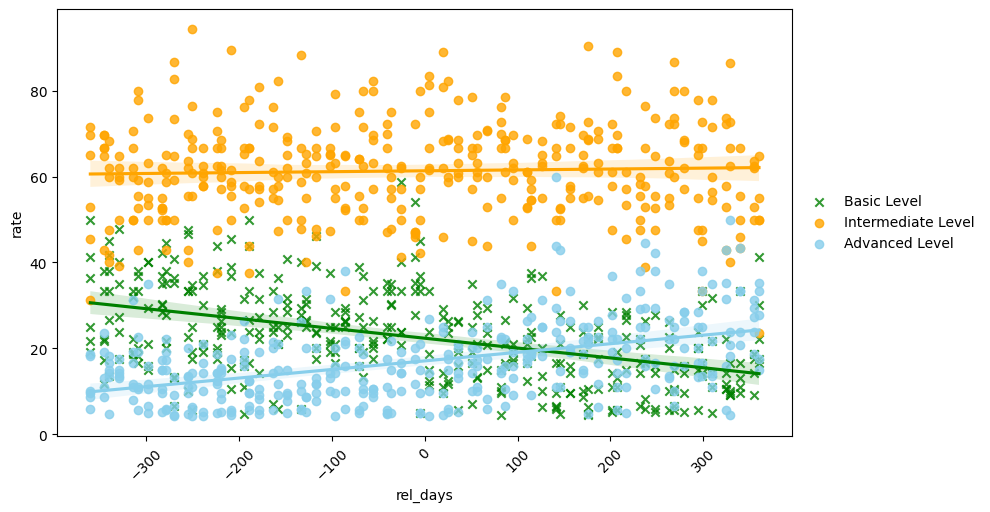

In [24]:
fig, ax = plt.subplots( figsize = (10, 5), sharey=True, sharex=True)




#create scatterplot with regression line
sns.regplot(  data=m_chk_cnt_0
            , x="rel_days"
            , y="rate"
            , ci=99
            , marker="x"
            , color=".5"
            , scatter_kws={"color": "green"}
            , line_kws={"color": "green"}
            , label = 'Basic Level')

sns.regplot(  data=m_chk_cnt_1
            , x="rel_days"
            , y="rate"
            , ci=99
            # , marker="o"
            , color=".3"
            , scatter_kws={"color": "orange"}
            , line_kws={"color": "orange"}
            , label = 'Intermediate Level')

sns.regplot(  data=m_chk_cnt_2
            , x="rel_days"
            , y="rate"
            , ci=99
            # , marker="o"
            , color=".3"
            , scatter_kws={"color": "skyblue"}
            , line_kws={"color": "skyblue"}
            , label = 'Advanced Level')

# ax.scatter(m_chk_cnt_0.creationdate, m_chk_cnt_0.rate, # specify data
#         color = 'red',
#         label = 'Basic',
#         marker='*',
#         linestyle='--',
#         trendline="ols"
# ) 

# ax.scatter(m_chk_cnt_1.creationdate, m_chk_cnt_1.rate, # specify data
#         color = 'orange',
#         label = 'Intermediate',
#         marker='*',
#         linestyle='--',
#         trendline="ols"
# ) 


# ax.scatter(m_chk_cnt_2.creationdate, m_chk_cnt_2.rate, # specify data
#         color = 'green',
#         label = 'Advanced',
#         marker='*',
#         linestyle='--',
#         trendline="ols"
# ) 

ax.legend(loc="center left", bbox_to_anchor=[1, 0.5], frameon=False)

# ax.axvline(major_xticks[25], # add vertical line
#            color = 'blue',
#            linestyle = '--',
#            linewidth = 1.5)


# ax.set_xticks(major_xticks)

plt.tight_layout()  
plt.xticks(rotation=45)
# plt.xscale('log');
plt.show();

In [25]:
m_chk_cnt_0[m_chk_cnt_0['rel_days'] ==1]

,creationdate,rel_days,o_result,rate


In [26]:
st_0 = st.Stats(m_chk_cnt_0['rel_days'].values, m_chk_cnt_0['rate'].values, 2, 0.95)
st_1 = st.Stats(m_chk_cnt_1['rel_days'].values, m_chk_cnt_1['rate'].values, 2, 0.95)
st_2 = st.Stats(m_chk_cnt_2['rel_days'].values, m_chk_cnt_2['rate'].values, 2, 0.95)

In [27]:
F_stat_0, p_value_0 = st_0.chow_test()
F_stat_1, p_value_1 = st_1.chow_test()
F_stat_2, p_value_2 = st_2.chow_test()

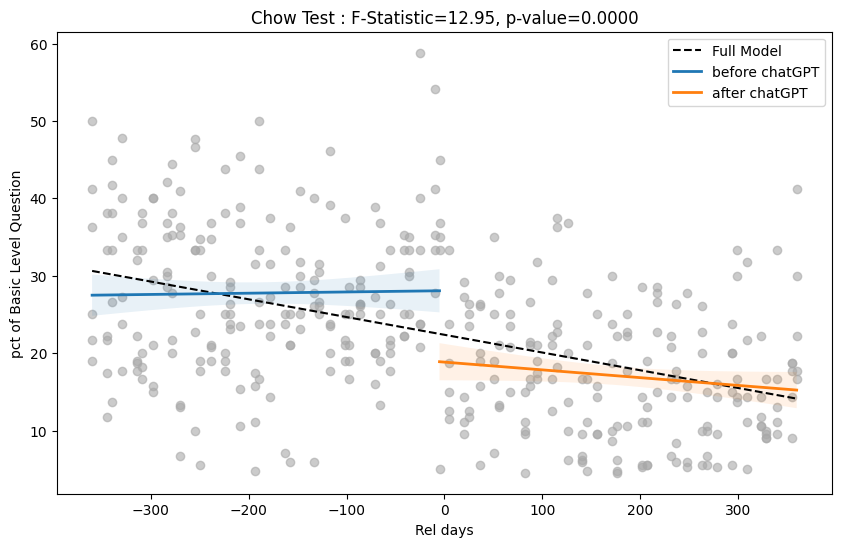

In [28]:
x = m_chk_cnt_0['rel_days'].values
y = m_chk_cnt_0['rate'].values

split_idx = np.argmax(np.where(x <= 0))
x1= x[:split_idx]
x2= x[split_idx:]
# 시각화
plt.figure(figsize=(10, 6))
plt.scatter(x, y,  alpha=0.6, color='darkgray')
plt.plot(x, st_0.y_predict, label="Full Model", linestyle="--", color="black")  


plt.plot(x1, st_0.y1_predict, label="before chatGPT", linewidth='2')
plt.fill_between(x1, st_0.y1_predict - st_0.y1_conf_interval, st_0.y1_predict + st_0.y1_conf_interval, alpha=0.1)

plt.plot(x2, st_0.y2_predict, label="after chatGPT", linewidth='2')
plt.fill_between(x2, st_0.y2_predict - st_0.y2_conf_interval, st_0.y2_predict + st_0.y2_conf_interval, alpha=0.1)


plt.legend()
plt.title(f"Chow Test : F-Statistic={F_stat_0:.2f}, p-value={p_value_0:.4f}")
plt.xlabel("Rel days")
plt.ylabel("pct of Basic Level Question")
plt.show()


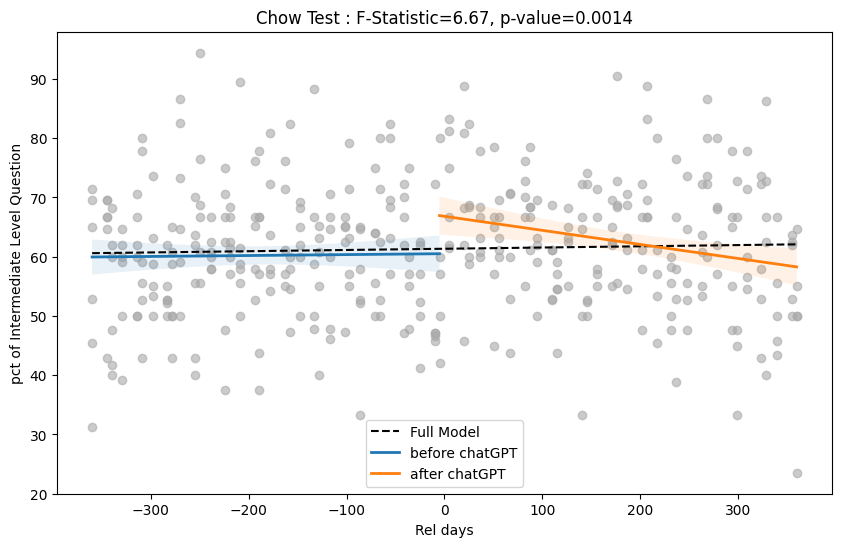

In [32]:
x = m_chk_cnt_1['rel_days'].values
y = m_chk_cnt_1['rate'].values

split_idx = np.argmax(np.where(x <= 0))
x1= x[:split_idx]
x2= x[split_idx:]
# 시각화
plt.figure(figsize=(10, 6))
plt.scatter(x, y,  alpha=0.6, color='darkgray')
plt.plot(x, st_1.y_predict, label="Full Model", linestyle="--", color="black")  


plt.plot(x1, st_1.y1_predict, label="before chatGPT", linewidth='2')
plt.fill_between(x1, st_1.y1_predict - st_1.y1_conf_interval, st_1.y1_predict + st_1.y1_conf_interval, alpha=0.1)

plt.plot(x2, st_1.y2_predict, label="after chatGPT", linewidth='2')
plt.fill_between(x2, st_1.y2_predict - st_1.y2_conf_interval, st_1.y2_predict + st_1.y2_conf_interval, alpha=0.1)


plt.legend()
plt.title(f"Chow Test : F-Statistic={F_stat_1:.2f}, p-value={p_value_1:.4f}")
plt.xlabel("Rel days")
plt.ylabel("pct of Intermediate Level Question")
plt.show()


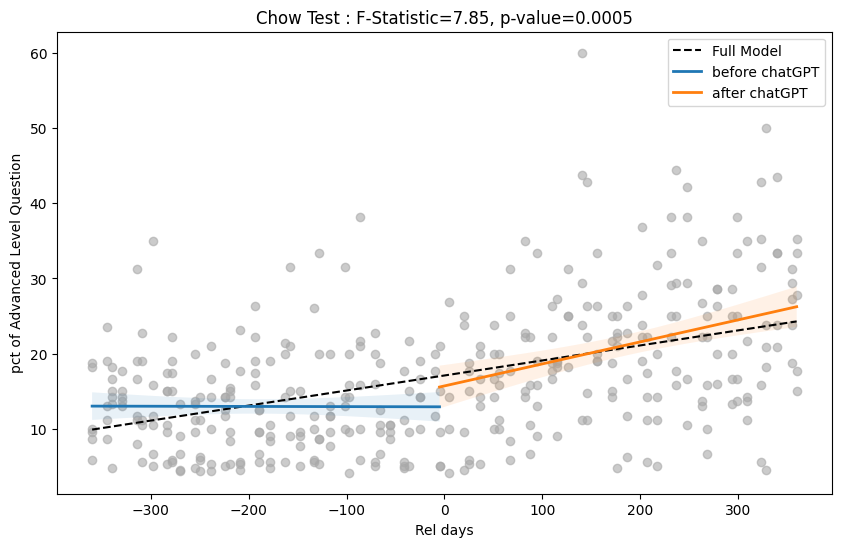

In [31]:
x = m_chk_cnt_2['rel_days'].values
y = m_chk_cnt_2['rate'].values

split_idx = np.argmax(np.where(x <= 0))
x1= x[:split_idx]
x2= x[split_idx:]
# 시각화
plt.figure(figsize=(10, 6))
plt.scatter(x, y,  alpha=0.6, color='darkgray')
plt.plot(x, st_2.y_predict, label="Full Model", linestyle="--", color="black")  


plt.plot(x1, st_2.y1_predict, label="before chatGPT", linewidth='2')
plt.fill_between(x1, st_2.y1_predict - st_2.y1_conf_interval, st_2.y1_predict + st_2.y1_conf_interval, alpha=0.1)

plt.plot(x2, st_2.y2_predict, label="after chatGPT", linewidth='2')
plt.fill_between(x2, st_2.y2_predict - st_2.y2_conf_interval, st_2.y2_predict + st_2.y2_conf_interval, alpha=0.1)


plt.legend()
plt.title(f"Chow Test : F-Statistic={F_stat_2:.2f}, p-value={p_value_2:.4f}")
plt.xlabel("Rel days")
plt.ylabel("pct of Advanced Level Question")
plt.show()
